In [102]:
%load_ext autoreload
%autoreload 2
%cd Autocatalytic-Reaction-Networks/

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import string
from tqdm import tqdm
import math

from Github.kauffman_network_helper import *
from Github.theoretical_estimate_helper import *
from Github.catalytic_schemes import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: 'Autocatalytic-Reaction-Networks/'
/Users/varunvaranasi/Documents/Yale/Research/Jun/Autocatalytic-Reaction-Networks


/Users/varunvaranasi/Documents/Yale/Research/Jun/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


#### Plotting Helper Functions

In [77]:

def label_panels(axes, x=-0.08, y=1.02, fontsize=16, weight='bold'):
    """
    Add (a), (b), (c), ... to a list or array of axes.
    x,y are in axes fraction coordinates (0..1).
    """
    axes = axes.flat if hasattr(axes, "flat") else axes
    for i, ax in enumerate(axes):
        ax.text(x, y, f"{string.ascii_lowercase[i]})",
                transform=ax.transAxes, ha='left', va='bottom',
                fontsize=fontsize, fontweight=weight)

# usage

In [24]:
from cycler import cycler

plt.style.use("default")
plt.rcParams.update({
    #"axes.prop_cycle": cycler(color=cycle),
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    #"axes.edgecolor": palette["charcoal"],
    #"axes.labelcolor": palette["charcoal"],
    #"xtick.color": palette["charcoal"],
    #"ytick.color": palette["charcoal"],
    #"grid.color": palette["silver"],
    "grid.linewidth": 0.7,
    "axes.grid": False,
    "legend.frameon": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "lines.linewidth": 1,
    "lines.markersize": 6.5,
    "axes.spines.top": False,
    "axes.spines.right": False
})

### Figure 1: Visualization of Kauffman Network

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch, Patch
from matplotlib.lines import Line2D

def draw_kauffman_network(
    molecules, foodset, reactions, catalysts,
    # layout / geometry
    outer_radius=1.0, inner_radius=0.6, start_angle=0.0,
    # edge styling
    base_curve=0.2, catalyst_curve=0.25,
    reaction_color="gray", catalyst_color="#9E2A2B",
    chaos_seed=42,
    linewidth = 2,
    # node styling
    node_size_mol=600, node_size_rxn=300, node_scale=1.0,
    food_color="#A8D8FF", show_labels=False,
    # legend controls
    include_legend=False, legend_loc="upper right",
    legend_bbox=None, legend_ncol=1, legend_fontsize=14,
    legend_frame=False, legend_borderaxespad=0.5, legend_labels=None,
    # figure control
    fig=None, ax=None, fig_size=None,
    title=None
):
    """
    Draws a Kauffman / RAF network and returns the matplotlib figure handle.
    Compatible with subplots: pass an existing (fig, ax) to draw into.
    """

    rng = np.random.default_rng(chaos_seed)

    # ---------- figure handling ----------
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=fig_size if fig_size else (6, 6))
    plt.sca(ax)

    # ---------- helpers ----------
    def _circle_positions(names, radius=1.0, start_angle=0.0):
        k = max(1, len(names))
        thetas = np.linspace(0, 2*np.pi, k, endpoint=False) + start_angle
        return {n: np.array([radius*np.cos(t), radius*np.sin(t)]) for n, t in zip(names, thetas)}, \
               {n: float(t) for n, t in zip(names, thetas)}

    def _angle_diff(a, b):
        return (b - a + np.pi) % (2*np.pi) - np.pi

    def curved_arrow(ax, p1, p2, color, alpha, width, curve, arrow=True):
        patch = FancyArrowPatch(
            p1, p2,
            connectionstyle=f"arc3,rad={curve}",
            arrowstyle='-|>' if arrow else '-',
            mutation_scale=8 + 2*width,
            lw=width, color=color, alpha=alpha,
            zorder=0, shrinkA=5, shrinkB=5
        )
        ax.add_patch(patch)

    # ---------- build edge lists ----------
    reaction_edges, catalyst_edges = [], []
    for r, (reacts, prods) in reactions.items():
        for x in reacts:  reaction_edges.append((x, r))
        for y in prods:   reaction_edges.append((r, y))
    for m, rlist in catalysts.items():
        for r in rlist:   catalyst_edges.append((m, r))

    # ---------- layout ----------
    pos_mol, ang_mol = _circle_positions(molecules, radius=outer_radius, start_angle=start_angle)
    offset = (np.pi/len(reactions)) if reactions else 0.0
    pos_rxn, ang_rxn = _circle_positions(list(reactions.keys()), radius=inner_radius, start_angle=start_angle+offset)
    pos, ang = {**pos_mol, **pos_rxn}, {**ang_mol, **ang_rxn}

    # ---------- graph + nodes ----------
    G = nx.DiGraph()
    G.add_nodes_from(molecules, kind='molecule')
    G.add_nodes_from(reactions.keys(), kind='reaction')

    node_colors, node_edges, node_sizes = [], [], []
    for n in G.nodes():
        if n in foodset:
            color = food_color
        elif G.nodes[n]['kind'] == 'molecule':
            color = "white"
        else:
            color = "black"
        node_colors.append(color)
        node_edges.append("black" if G.nodes[n]['kind']=='molecule' else "none")
        base_size = node_size_mol if G.nodes[n]['kind']=='molecule' else node_size_rxn
        node_sizes.append(base_size * node_scale)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors=node_edges, node_size=node_sizes, ax=ax)

    # ---------- draw edges ----------
    def draw_edges(edges, color, base_c, invert=False,
                   width_mean=0.9, width_std=0.25, alpha_mean=0.5, alpha_std=0.25):
        for (u, v) in edges:
            w = max(0.2, width_mean + rng.normal(0, width_std))
            a = float(np.clip(alpha_mean + rng.normal(0, alpha_std), 0.05, 1.0))
            dtheta = abs(_angle_diff(ang[u], ang[v]))
            scale = 1.0 + 1.2 * (1 - np.cos(dtheta)) / 2.0
            base_here = base_c * scale
            c = rng.choice([-1, 1]) * base_here * rng.uniform(0.8, 1.4)
            if invert: c = -c
            curved_arrow(ax, pos[u], pos[v], color=color, alpha=a, width=w, curve=c, arrow=True)

    draw_edges(reaction_edges, reaction_color, base_curve, invert=False, 
               width_mean=linewidth, width_std=0.30, alpha_mean=0.50, alpha_std=0.25)
    draw_edges(catalyst_edges, catalyst_color, catalyst_curve, invert=True,
               width_mean=linewidth, width_std=0.25, alpha_mean=0.35, alpha_std=0.25)

    # ---------- labels (optional) ----------
    if show_labels:
        for n, (x, y) in pos.items():
            ax.text(x, y, n, ha='center', va='center',
                    fontsize=14, color=('black' if G.nodes[n]['kind']=='molecule' else 'white'))

    # ---------- legend ----------
    if include_legend:
        default_labels = {
            "molecule": "X",
            "food":     "F",
            "reaction": "R node",
            "reaction_edge": "Reaction flow",
            "catalyst_edge": "Catalysis",
        }
        legend_labels = (legend_labels or {})
        for k, v in default_labels.items():
            legend_labels.setdefault(k, v)

        handles = [
            Patch(facecolor="white", edgecolor="black", label=legend_labels["molecule"]),
            Patch(facecolor=food_color, edgecolor="black", label=legend_labels["food"]),
            Patch(facecolor="black", edgecolor="none", label=legend_labels["reaction"]),
            Line2D([0], [0], color=reaction_color, lw=2, label=legend_labels["reaction_edge"]),
            Line2D([0], [0], color=catalyst_color, lw=2, label=legend_labels["catalyst_edge"]),
        ]
        ax.legend(
            handles=handles,
            loc=legend_loc,
            bbox_to_anchor=legend_bbox,
            frameon=legend_frame,
            fontsize=legend_fontsize,
            borderaxespad=legend_borderaxespad,
            ncol=legend_ncol
        )

    # ---------- cleanup ----------
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=20)

    return fig, ax


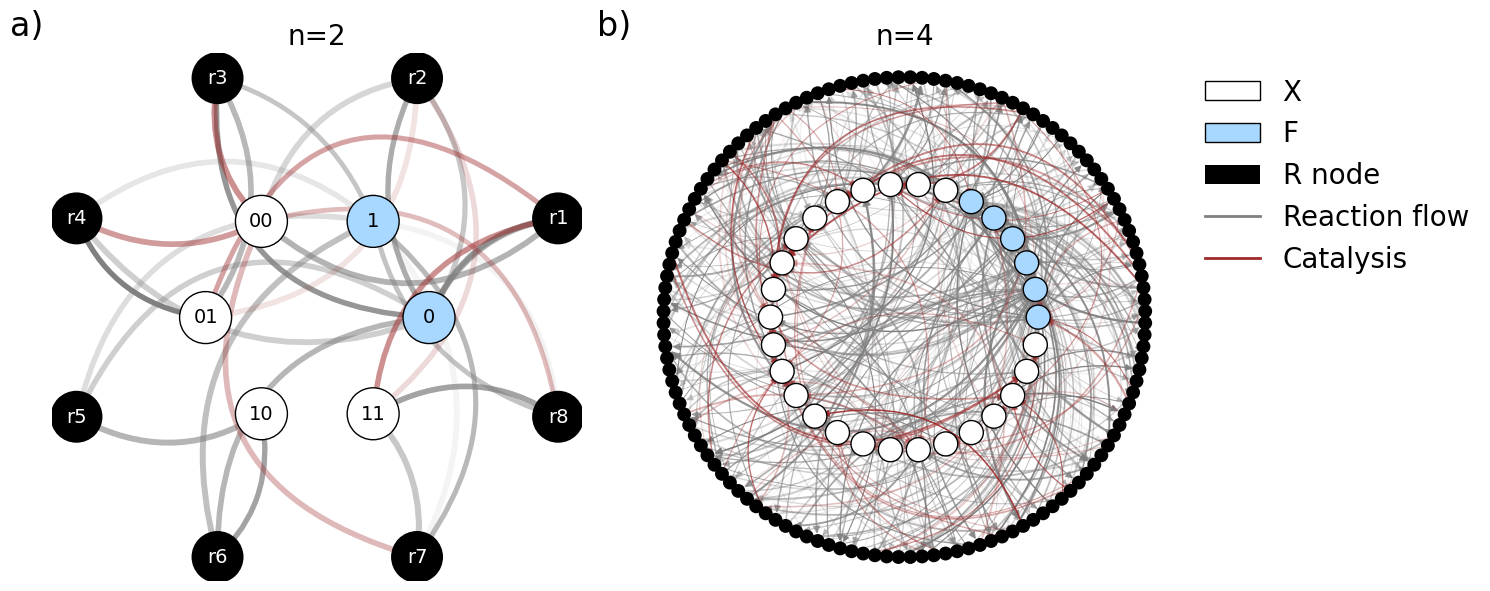

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15,6 ))

X,F,R = create_XFR(2)

X = ['0', '1', '00', '01', '10','11']
F = ['0', '1']
R = {'r1': [['0', '0'], ['00']],
 'r2': [['00'], ['0', '0']],
 'r3': [['0', '1'], ['01']],
 'r4': [['01'], ['0', '1']],
 'r5': [['1', '0'], ['10']],
 'r6': [['10'], ['1', '0']],
 'r7': [['1', '1'], ['11']],
 'r8': [['11'], ['1', '1']]}

C = {'r3': ['00'], 'r4': ['00'], 'r7': ['00'], 'r8': ['00'], 'r1': ['01', '11'], 'r2': ['01', '11'],
     }


# Left subplot
draw_kauffman_network(
    X, F, R, C,
    outer_radius=0.3, inner_radius=0.7, chaos_seed=1,node_size_mol=700, node_size_rxn=700,node_scale=2.0,
    fig=fig, ax=axes[0], title="n=2",legend_fontsize = 14, show_labels = True, linewidth = 4
)


X,F,R = create_XFR(4)
C = create_uniform_catalysts(X, len(R), 1.25)

# Right subplot
draw_kauffman_network(
    X, F, R, C,
    outer_radius=0.5, inner_radius=0.9, chaos_seed=10, node_size_mol=300, node_size_rxn=100,
    catalyst_color="#9E2A2B", reaction_color="gray",
    fig=fig, ax=axes[1], title="n=4", include_legend=True,
    legend_loc="upper left", legend_bbox=(1.02, 1.0),legend_fontsize = 20, linewidth = 1
)

label_panels(np.array(axes), fontsize = 24, weight='normal')
plt.tight_layout()
plt.show()

### Figure 2: Probabilistic Emergence of RAF in Simulation

Plotting Data generated from RAF_Emergence_Sim.py

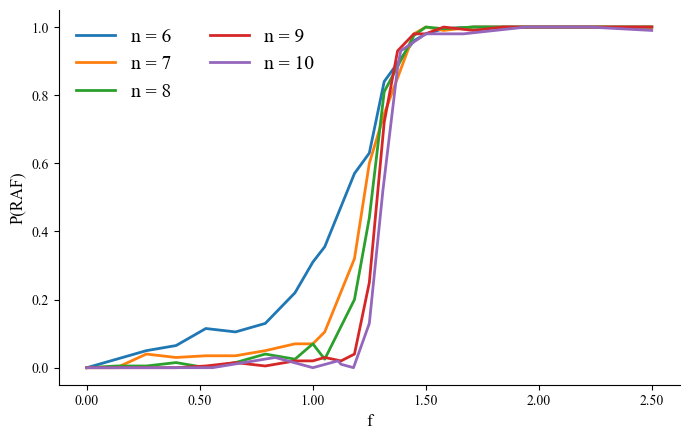

In [128]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

# --- data ---
file_path = 'Github/raf_results.csv'
all_runs_data = pd.read_csv(file_path)

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 4.5))

# Tableau 10 palette
tab10 = plt.get_cmap('tab10').colors  # tuple of 10 RGB colors

# stable ordering so color assignment is consistent across runs
n_vals = sorted(all_runs_data.n.unique())

for i, n_val in enumerate(n_vals):
    if n_val <= 5:
        continue
    plot_df = all_runs_data[all_runs_data.n == n_val].sort_values('f')

    ax.plot(
        plot_df.f,
        plot_df.raf_prob,
        label=f"n = {n_val}",
        color=tab10[i % len(tab10)],
        linewidth=2.0,
    )

# axes / styling
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.set_xlabel('f')
ax.set_ylabel('P(RAF)')

# compact legend
ax.legend(fontsize=14, frameon=False, ncol=2)

fig.tight_layout()
plt.show()


### Fig 3: Emergence Regimes

In [ ]:
N = 10

batch_size = 50
contain_singles_pct = []
f_count = 20

pcts_holder = np.zeros((f_count, N))

fs_pct_single = np.linspace(0.1, 2.5, f_count)

for j,f in tqdm(enumerate(fs_pct_single)):
    raf_count = 0
    contain_singles = 0

    for i in range(N):
        for b in range(batch_size):

            X, F, R = X_copy.copy(), F_copy.copy(), R_copy.copy()
            C = create_uniform_catalysts(X, len(R), f)
            if RAF(F, R, C):
                raf_count +=1 
                contain_singles += any_key_value_match(C, single_solutions)

        if raf_count != 0:
            pcts_holder[j][i] = contain_singles/raf_count

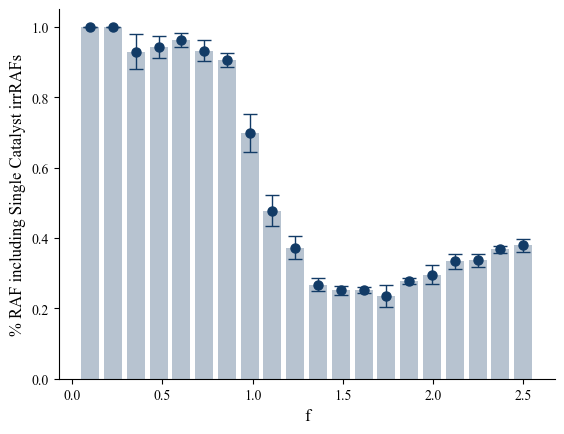

In [599]:
plt.errorbar(fs_pct_single, np.mean(pcts_holder, axis = 1), yerr = np.std(pcts_holder, axis = 1), fmt ='o',capsize=5,
       color=sim_color)
plt.bar(fs_pct_single, np.mean(pcts_holder, axis = 1), alpha = 0.3, width = 0.1,
       color=sim_color)
plt.xlabel('f')
plt.ylabel('% RAF including Single Catalyst irrRAFs')
plt.show()

### Figure 5: RAF Emergence can be estimated by the complementary CDF of the distribution of total catalysts and Finite Size Corrections

##### Producing Data for Fig 3a: Growth of $B_k$ and $S \choose k$

In [11]:
def f_linear_fit(n):
    return 1.0970 + 0.0189 * n

In [12]:
n = 6

# Size of irrRAF core set chosen to be proportional to R as proven in paper (the number 500 is selected to replicate observed results)
Q_new = np.sqrt(n * 2**n) * 500


X, F, R = create_XFR(n)
mR = len(X) * len(R) / 2
k_estimate = (2**(n+1) - 2) * f_linear_fit(n)
k_values = np.arange(int(k_estimate * 0.6), int(k_estimate * 1.3))
#k_values = np.arange(1, 300)

conditional_probability = [
        np.exp(
            min(
                log_sum(raf_term(i, mR, Q_new, k_prime=(2**(n+1)-2)*f_linear_fit(n), n=n))
                - wiki_approx(mR, i),
                0
            )
        )
        for i in k_values
    ]


k_prime = k_values[np.argmax(conditional_probability)]


b_k = [log_sum(raf_term(i, mR, Q_new, k_prime=(2**(n+1)-2)*f_linear_fit(n), n=n)) for i in k_values]
binom_term = [wiki_approx(mR, i) for i in k_values]


In [103]:
k_primes = []
scaling_factors = np.linspace(1,1000, 25)

for s in scaling_factors:
    n = 6

    # Size of irrRAF core set chosen to be proportional to R as proven in paper (the number 500 is selected to replicate observed results)
    Q_new = np.sqrt(n * 2**n) * s


    X, F, R = create_XFR(n)
    mR = len(X) * len(R) / 2
    k_estimate = (2**(n+1) - 2) * f_linear_fit(n)
    k_values = np.arange(int(k_estimate * 0.6), int(k_estimate * 1.3))
    #k_values = np.arange(1, 300)

    conditional_probability = [
            np.exp(
                min(
                    log_sum(raf_term(i, mR, Q_new, k_prime=(2**(n+1)-2)*f_linear_fit(n), n=n))
                    - wiki_approx(mR, i),
                    0
                )
            )
            for i in k_values
        ]


    k_prime = k_values[np.argmax(conditional_probability)]

    k_primes.append(k_prime)


Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple


/Users/varunvaranasi/Documents/Yale/Research/Jun/Autocatalytic-Reaction-Networks/Github/theoretical_estimate_helper.py:42: RuntimeWarning: overflow encountered in exp
  else:
/Users/varunvaranasi/Documents/Yale/Research/Jun/Autocatalytic-Reaction-Networks/Github/theoretical_estimate_helper.py:42: RuntimeWarning: invalid value encountered in scalar subtract
  else:


Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple
Not Simple


In [556]:
import numpy as np
from scipy.special import logsumexp

def log_sum(vals, nan_policy="omit"):
    v = np.asarray(vals, dtype=float)
    v = v[~np.isnan(v)]
    if v.size == 0:
        return -np.inf   # log(0)

    return logsumexp(v)

    
n = 6

# Size of irrRAF core set chosen to be proportional to R as proven in paper (the number 500 is selected to replicate observed results)
Q_new = np.sqrt(n * 2**n) * 500


X, F, R = create_XFR(n)
mR = len(X) * len(R) / 2
k_estimate = (2**(n+1) - 2) * f_linear_fit(n)
k_values = np.arange(int(k_estimate * 0.8), int(k_estimate * 1.2))
#k_values = np.arange(1, 300)

conditional_probability = [
        np.exp(
            min(
                log_sum(raf_term(i, mR, Q_new, k_prime=(2**(n+1)-2)*f_linear_fit(n), n=n))
                - log_gamma_approx(mR, i),
                0
            )
        )
        for i in k_values
    ]

min_bound = 1- np.exp([(np.log(mR - 96) - np.log(mR))*k for k in k_values])

k_prime = k_values[np.argmax(conditional_probability)]

max_curve = [max(a, b) for a, b in zip(min_bound, conditional_probability)]


b_k = [log_sum(raf_term(i, mR, Q_new, k_prime=(2**(n+1)-2)*f_linear_fit(n), n=n)) for i in k_values]
binom_term = [log_gamma_approx(mR, i) for i in k_values]


Text(0, 0.5, 'Log Counts')

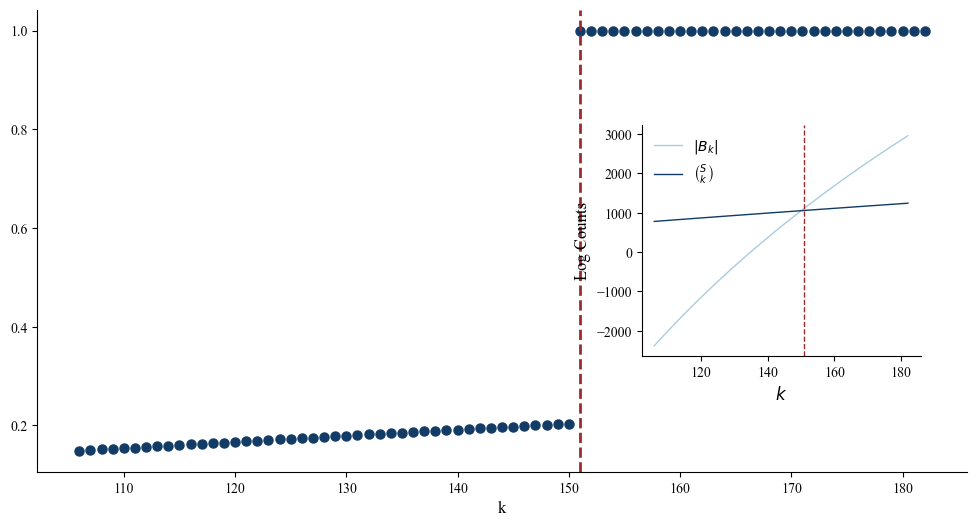

In [552]:
cols = ['#a9cce3', '#80a9c9', '#5787af', '#2d6495', '#123b66']
k_prime_color = '#9E2A2B'
sim_color     = cols[-1]
theory_color  = '#FFC107'

b_k_color     = cols[0]
binom_color   = cols[-1]
cond_prob_color = cols[-1]

fig, ax_main = plt.subplots(1,1, figsize = (12,6))

ax_main.scatter(k_values, max_curve, color=cond_prob_color)
ax_main.axvline(k_prime, ls="--", lw=2, color=k_prime_color, label=f"$k' = {k_prime}$")
ax_main.set_xlabel('k')

# inset
ax_inset = ax_main.inset_axes([0.65, 0.25, 0.3, 0.5])
ax_inset.plot(k_values, b_k, label='$|B_k|$', color=b_k_color)
ax_inset.plot(k_values, binom_term, label=r'$\binom{S}{k}$', color=binom_color)
ax_inset.axvline(k_prime, color=k_prime_color, lw=1, ls="--")
ax_inset.legend(fontsize=10, frameon=False, loc='upper left')
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.set_xlabel('$k$')
ax_inset.set_ylabel('Log Counts')

##### Producing Data for 3b: Distribution of Catalytic Pairs

In [73]:
N, n = 1000, 6
X, F, R = create_XFR(n)
X_copy = X.copy()
F_copy = F.copy()
R_copy = R.copy()
fs_dist = [0.5, 1.25, 2]
cols = ['#1B4F72', '#2E86C1', '#85C1E9']

color_idx = 0

uniform_distributions = {}

for i,f in enumerate(fs_dist):
    
    counts, raf_count = [], 0
    for _ in range(N):
        X, F, R = X_copy.copy(), F_copy.copy(), R_copy.copy()
        C = create_uniform_catalysts(X, len(R), f)
        #raf_count += RAF(F, R, C)
        counts.append(sum(len(v) for v in C.values())/2)

  

    uniform_distributions[f] = [counts] 

##### Producing Data for 3c: Alignment of Theory and Simulation Curves

In [75]:
N, n = 100, 6
X, F, R = create_XFR(n)
X_copy = X.copy()
F_copy = F.copy()
R_copy = R.copy()
fs = np.linspace(0, 2, 9)#[0.25, 0.5, 0.75, 1.25,1.5, 2]

rafs = []

for i,f in enumerate(fs):
    counts, raf_count = [], 0
    for _ in range(N):
        X, F, R = X_copy.copy(), F_copy.copy(), R_copy.copy()
        C = create_uniform_catalysts(X, len(R), f)
        raf_count += RAF(F, R, C)
        #counts.append(sum(len(v) for v in C.values())/2)
    rafs.append(raf_count / N)


f_theory = np.linspace(0,2, 100)
theory_curve = [1- np.dot(uniformCatalysis(n, f).pdf(k_values), conditional_probability) for f in f_theory]#[1 - uniformCatalysis(n,f).cdf(k_prime-1) for f in f_theory]

In [134]:
n = 6

# Size of irrRAF core set chosen to be proportional to R as proven in paper (the number 500 is selected to replicate observed results)
Q_new = np.sqrt(n * 2**n) * 500


X, F, R = create_XFR(n)
mR = len(X) * len(R) / 2
k_estimate = (2**(n+1) - 2) * f_linear_fit(n)
#k_values = np.arange(int(k_estimate * 0.6), int(k_estimate * 1.3))
k_values_theory = np.arange(1, 300)

conditional_probability_theory = [
        np.exp(
            min(
                log_sum(raf_term(i, mR, Q_new, k_prime=(2**(n+1)-2)*f_linear_fit(n), n=n))
                - log_gamma_approx(mR, i),
                0
            )
        )
        for i in k_values_theory
    ]

min_bound = 1- np.exp([(np.log(mR - 96) - np.log(mR))*k for k in k_values_theory])

max_curve = [max(a, b) for a, b in zip(min_bound, conditional_probability_theory)]


f_theory = np.linspace(0,2, 100)
theory_curve = [np.dot(uniformCatalysis(n, f).pdf(k_values_theory), max_curve) for f in f_theory]
theory_curve_old = [1 - uniformCatalysis(n,f).cdf(k_prime-1) for f in f_theory]

##### Generating Plot

/var/folders/rz/8ns_4y5958ldxyg1ckf2wd0c0000gn/T/ipykernel_15851/4152004256.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/rz/8ns_4y5958ldxyg1ckf2wd0c0000gn/T/ipykernel_15851/4152004256.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


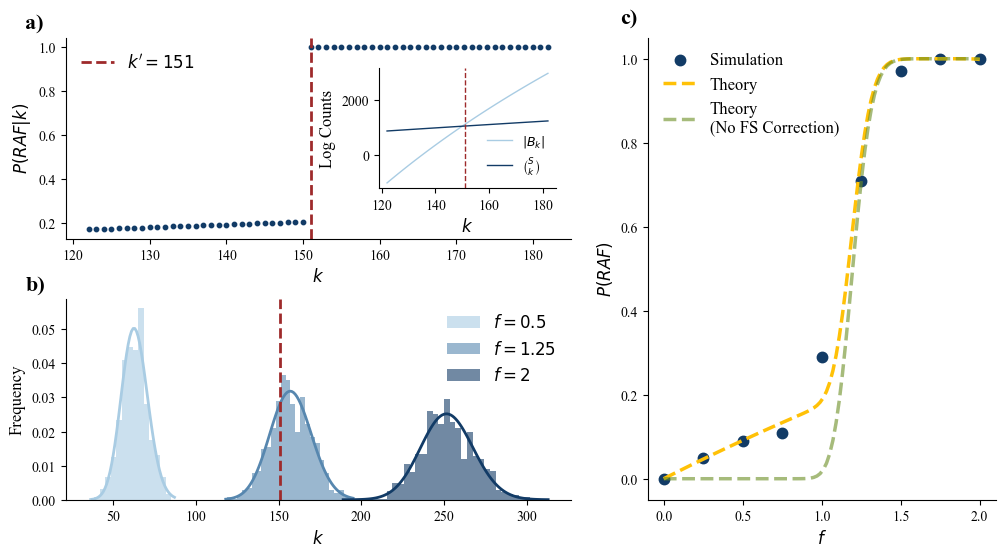

In [585]:


fs = np.linspace(0, 2, 9)

# --- COLORS -------------------------------------------------------------
cols = ['#a9cce3', '#80a9c9', '#5787af', '#2d6495', '#123b66']
k_prime_color = '#9E2A2B'
sim_color     = cols[-1]
theory_color  = '#FFC107'

b_k_color     = cols[0]
binom_color   = cols[-1]
cond_prob_color = cols[-1]

# --- FIGURE + GRID ------------------------------------------------------
fig = plt.figure(figsize=(12, 6), constrained_layout=True)

# Grid: 2 rows × 2 columns
# Left column: stacked panels (top-left & bottom-left)
# Right column: one tall panel (theory)
gs = gridspec.GridSpec(
    2, 2, figure=fig,
    width_ratios=[1.6, 1.1],    # right column wider
    height_ratios=[1.0, 1.0],   # two equal-height left panels
    wspace=0.18, hspace=0.3
)

# Left column stacked
ax_main = fig.add_subplot(gs[0, 0])    # top-left  → (a)
ax2     = fig.add_subplot(gs[1, 0])    # bottom-left → (b)
# Right column spans both rows → (c)
ax3     = fig.add_subplot(gs[:, 1])

# --- PLOTTING -----------------------------------------------------------

# Panel (a): conditional probability
ax_main.scatter(k_values, max_curve, color=cond_prob_color, s= 10)
ax_main.axvline(k_prime, ls="--", lw=2, color=k_prime_color, label=f"$k' = {k_prime}$")
ax_main.set_xlabel('k')

# inset
ax_inset = ax_main.inset_axes([0.62, 0.25, 0.35, 0.6])
ax_inset.plot(k_values, b_k, label='$|B_k|$', color=b_k_color)
ax_inset.plot(k_values, binom_term, label=r'$\binom{S}{k}$', color=binom_color)
ax_inset.axvline(k_prime, color=k_prime_color, lw=1, ls="--")
ax_inset.legend(fontsize=9, frameon=False, )
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax_inset.set_xlabel('$k$')
ax_inset.set_ylabel('Log Counts')

# Panel (b): distributions
for i, f in enumerate(fs_dist):
    if f < 1:
        bin_count = 15
    else:
        bin_count = 30

    ax2.hist(uniform_distributions[f], bins=bin_count, alpha=0.6,
             label=f"$f = {f}$", density=True, color=cols[i*2])
    unif = uniformCatalysis(n, f)
    scaling = 10 if unif.x_min < 48 else 0
    xs = np.arange(int(unif.x_min) - scaling, int(unif.x_max) + scaling, 1)
    ax2.plot(xs, unif.pdf(xs), lw=2, color=cols[i*2])
ax2.axvline(k_prime, ls="--", lw=2, color=k_prime_color)
ax2.set_xlabel('$k$')
ax2.set_ylabel('Frequency', fontsize = 12)

# Panel (c): theory vs simulation
ax3.scatter(fs, rafs, marker="o", lw=2, color=sim_color, label='Simulation')
ax3.plot(f_theory, theory_curve, lw=2.5, ls="--",
         color=theory_color, label='Theory')

ax3.plot(f_theory, theory_curve_old, lw=2.5, ls="--", alpha = 0.6,
         color='olivedrab', label='Theory\n(No FS Correction)')
ax3.set_xlabel('$f$')
ax3.set_ylabel('$P(RAF)$', fontsize = 12)

# --- FORMATTING ---------------------------------------------------------
ax_main.set_xlabel('$k$')
ax_main.set_ylabel('$P(RAF|k)$', fontsize = 12)
ax_main.legend(fontsize=12, frameon=False, loc='upper left')
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

ax2.legend(fontsize=12, frameon=False, loc='upper right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.legend(fontsize=12, frameon=False, loc='upper left')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# panel labels (a, b, c)
label_panels(np.array([ax_main, ax2, ax3]))

# --- SAVE / SHOW --------------------------------------------------------
plt.tight_layout()
fig.savefig("Fig4.pdf",
            bbox_inches='tight', pad_inches=0.02)
plt.show()


### Figure 6: Theoretical model explains RAF emergence across catalytic schemes

##### Generating Simulation Data for Each Catalysis Models

In [324]:
def update_df(method, reps, fs, outputs, n=6):
    """
    Update or append simulation results for each f in fs.

    Each unique (method, f) combination keeps its own sequence of batch_ids,
    starting at 1 and incrementing by 1 for every new update.
    """
    file_path = f"n_{n}_sims.csv"

    # Create the file if it doesn't exist yet
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame(columns=["method", "f", "batch_id", "success", "total_runs"])

    for i, f_val in enumerate(fs):
        df["f"] = pd.to_numeric(df["f"], errors="coerce")
        # round f to avoid float mismatch
        f_rounded = round(float(f_val), 2)

        # find all existing rows for this (method, f)
        existing_batches = df[(df["method"] == method) & (df["f"].round(2) == f_rounded)]

        # next batch id logic
        next_batch_id = int(existing_batches["batch_id"].max()) + 1 if not existing_batches.empty else 1

        # create new batch entry
        new_row = pd.DataFrame({
            "method": [method],
            "f": [f_rounded],
            "batch_id": [next_batch_id],
            "success": [outputs[i]],
            "total_runs": [reps]
        })

        # append the new batch row
        df = pd.concat([df, new_row], ignore_index=True)

    # save back to csv
    df.to_csv(file_path, index=False)
    return df

In [323]:
def calculate_error_bars(df):
    """Calculate mean success rate and error bars for each method/f_param combination"""
    
    # Calculate success rate for each batch
    df['success_rate'] = df['success'] / df['total_runs']
    
    # Group by method and f_param to calculate statistics
    stats = df.groupby(['method', 'f']).agg({
        'success_rate': ['mean', 'std', 'count'],
        'success': 'sum',
        'total_runs': 'sum'
    }).reset_index()
    
    # Flatten column names
    stats.columns = ['method', 'f', 'mean_success_rate', 'std_success_rate', 'n_batches', 'suceess', 'total_runs']
    
    # Calculate standard error and confidence intervals
    stats['std_error'] = stats['std_success_rate'] / np.sqrt(stats['n_batches'])
    stats['ci_95_lower'] = stats['mean_success_rate'] - 1.96 * stats['std_error']
    stats['ci_95_upper'] = stats['mean_success_rate'] + 1.96 * stats['std_error']
    
    return stats

In [564]:
n = 6

df_data = pd.DataFrame(columns= ['method', 'f','batch_id', 'success', 'total_runs'])
df_data.to_csv(f'n_{n}_sims.csv', index= False)

N = 5
reps = 100

uniform_distributions_2 = {}
plaw_distributions_2 = {}
allornone_distributions_2 = {}
sparse_distributions_2 = {}

for i in range(N):
    print(i+1)
    
    fs = np.linspace(0,2.5,11)

    uniform_output = []
    
    for f in tqdm(fs):
        counts = []
        raf_count = 0
        for j in range(reps):
            X,F,R= create_XFR(n)
            C = create_uniform_catalysts(X, len(R),f)
            raf_count += RAF(F,R,C)
            counts.append(sum([len(c)/2 for c in C.values()]))

        uniform_distributions_2[f] = counts
        uniform_output.append(raf_count)


    update_df('Uniform', reps, fs,uniform_output,n=n )

    ######################################

    n = 6
 

    power_output = []
   
    for f in tqdm(fs):
        counts = []
        raf_count = 0
        plaw = powerlawCatalysis(n, f)
        for j in range(reps):
            X,F,R= create_XFR(n)
            C = create_powerlaw_catalysts(X, len(R),plaw.s)
            counts.append(sum([len(c)/2 for c in C.values()]))

            raf_count += RAF(F,R,C)
        #output.append([n, f, raf_count/reps])
        plaw_distributions_2[f] = counts
        power_output.append(raf_count)


    update_df('Power', reps, fs,power_output,n=n )

    #######################################
    n = 6
    #reps = 100
    

    allornone_output = []
    
    for f in tqdm(fs):
        counts = []
        raf_count = 0
        for j in range(reps):
            X,F,R= create_XFR(n)
            #p = f/len(R)
            C = create_allornone_catalysts(X, len(R),f)
            counts.append(sum([len(c)/2 for c in C.values()]))

            raf_count += RAF(F,R,C)
        #output.append([n, f, raf_count/reps])
        allornone_distributions_2[f] = counts
        allornone_output.append(raf_count)

    #print(raf_count/reps)
    update_df('All or None', reps, fs,allornone_output,n=n )

    ########################################

    n = 6


    sparse_output = []
    
    for f in tqdm(fs):
        counts = []
        raf_count = 0
        for j in range(reps):
            #p = f/len(R)
            X,F,R= create_XFR(n)
            C = create_sparse_catalysts(X, len(R),f,n)
            counts.append(sum([len(c)/2 for c in C.values()]))
            raf_count += RAF(F,R,C)
        #output.append([n, f, raf_count/reps])
        sparse_distributions_2[f] = counts
        sparse_output.append(raf_count)

    #print(raf_count/reps)
    update_df('Sparse', reps, fs, sparse_output,n=n )


1


100%|██████████| 11/11 [01:12<00:00,  6.57s/it]


2


100%|██████████| 11/11 [01:12<00:00,  6.57s/it]


3


100%|██████████| 11/11 [01:11<00:00,  6.51s/it]


4


100%|██████████| 11/11 [01:10<00:00,  6.43s/it]


5


100%|██████████| 11/11 [01:10<00:00,  6.45s/it]


##### Producing Theoretical Curves for Each Catalysis Model

In [355]:
n =6
X,F,R = create_XFR(n)
mR = len(R) * len(X)/2
max_it = int(mR * 10/len(R))



f_theoretical = np.linspace(0, 2.5, 50)

colors = ['#6B8E23', '#FFA500', '#ADD8E6', '#DC143C']
k_values = [i for i in range(1, max_it)]
conditional_probability = [np.exp(min(log_sum(raf_term(i, mR, Q_new,k_prime = (2**(n+1) -2) *f_linear_fit(n),  n= n)) - log_gamma_approx(mR, i), 0)) for i in k_values]
k_prime = k_values[conditional_probability.index(1)]

min_bound = 1- np.exp([(np.log(mR - 96) - np.log(mR))*k for k in k_values])
max_curve = [max(a, b) for a, b in zip(min_bound, conditional_probability)]


#k_prime = k_values[conditional_probability.index(1)]


uniform_theory = [np.dot(uniformCatalysis(n, f).pdf(k_values), max_curve) for f in f_theoretical] #[1- uniformCatalysis(n, f).cdf(k_prime) for f in f_theoretical]
plaw_theory = [np.dot([powerlawCatalysis(n, f).pdf(k) for k in k_values], max_curve) for f in f_theoretical] #[1- powerlawCatalysis(n, f).cdf(k_prime) for f in f_theoretical]
allornone_theory = [1- AllOrNoneCatalysis(n, f).cdf(k_prime) for f in f_theoretical] #[np.dot([AllOrNoneCatalysis(n, f).pdf(k) for k in k_values], max_curve) for f in f_theoretical] #
sparse_theory = [np.dot([SparseCatalysis(n, f).pdf(k) for k in k_values], max_curve) for f in f_theoretical] #[1- SparseCatalysis(n, f).cdf(k_prime) for f in f_theoretical]


In [362]:
plaw_theory = [ np.dot([powerlawCatalysis(n, f).pdf(k) for k in range(1, k_prime+1)], max_curve[:k_prime]) + 1- powerlawCatalysis(n, f).cdf(k_prime) for f in f_theoretical] #[1- powerlawCatnp.dot([powerlawCatalysis(n, f).pdf(k) for k in k_values], max_curve)alysis(n, f).cdf(k_prime) for f in f_theoretical]

##### Producing Figure

/var/folders/rz/8ns_4y5958ldxyg1ckf2wd0c0000gn/T/ipykernel_15851/856764228.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/rz/8ns_4y5958ldxyg1ckf2wd0c0000gn/T/ipykernel_15851/856764228.py:294: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


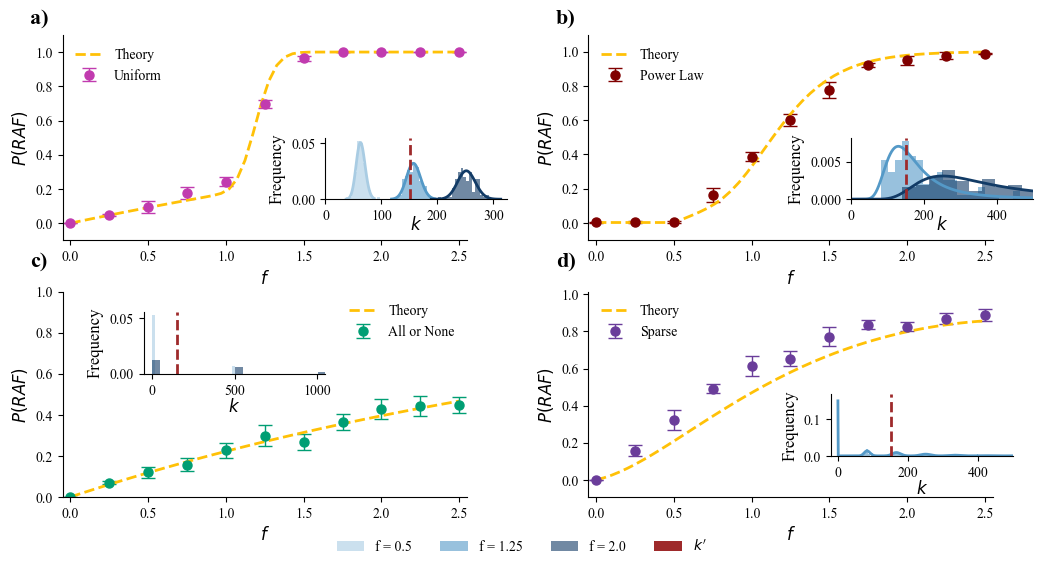

In [570]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import string
from matplotlib.patches import Patch
import pandas as pd

# --- Color palette ----------------------------------------------------
cols = ['#A9CCE3', '#80A9C9', '#5787AF', '#2D6495', '#123B66']

schemes =  {
    "Uniform":   "#C13BAF",  # deep turquoise
    "PowerLaw":  "maroon", #A02C2C",  # dark crimson
    "Sparse":    "#6A3D9A",  # vibrant purple
    "AllOrNone": "#009E73",  # teal green
}


# same palette for every inset
f_palette = {
    0.5:  '#A9CCE3',   # light blue
    1.25: '#5499C7',   # mid blue
    2.0:  '#123B66',   # dark navy
}

f_sets = {
    "Uniform":    [0.5, 1.25, 2.0],
    "PowerLaw":   [1.25, 2],
    "AllOrNone":  [0.5, 2.0],
    "Sparse":     [1.25],
}


sim_color     = cols[-1]
theory_color  = '#FFC107'
k_prime_color = '#9E2A2B'
dist_fill     = cols[0]


# --- Figure layout ----------------------------------------------------
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.25)

axes = []
for i in range(4):
    row, col = divmod(i, 2)
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)


df_data = pd.read_csv('../n_6_sims.csv')
#df_data =df_data[df_data.total_runs > 100]

stats_df = calculate_error_bars(df_data)


methods = ['Uniform', 'Power', 'All or None', 'Sparse']



# for i,m in enumerate(methods):
#     df = stats_df[stats_df.method == m]
    
#     ax1.errorbar(df.f, df.mean_success_rate, 
#         yerr=[df.std_error.values * 1.96, df.std_error.values *1.96],color= colors[i], fmt ='o',capsize=5,)


########### Uniform ###########
#axes[0].plot(fs, y_sim, color=sim_color, lw=2, label="Simulation")
df = stats_df[stats_df.method == 'Uniform']
axes[0].errorbar(df.f, df.mean_success_rate, yerr=[df.std_error.values * 1.96, df.std_error.values *1.96],color= schemes["Uniform"], fmt ='o',capsize=5, label = 'Uniform' )
axes[0].plot(f_theoretical, uniform_theory, color=theory_color, lw=2, ls="--", label="Theory")


###

axes[0].set_xlabel("$f$")
axes[0].set_ylabel("$P(RAF)$")
#ax.set_title(f"Uniform", fontsize=10, pad=2)
axes[0].margins(x=0.02, y=0.1)
axes[0].legend(fontsize=10, frameon=False, loc="best")

# Inset distribution
ax_inset = axes[0].inset_axes([0.65, 0.2, 0.45, 0.3])
for i,f in enumerate(f_sets['Uniform']):
    bins = np.concatenate(([ -0.5, 0.5 ], np.arange(1.5, max(uniform_distributions_2[f])+1.5, 5)))
    ax_inset.hist(uniform_distributions_2[f], bins=bins, alpha=0.6, label=f"$f = {f}$", density= True, color = f_palette[f])
    unif = uniformCatalysis(n,f)
    if unif.x_min < 48:
        scaling = 10
    else:
        scaling = 0
    
    xs = np.arange(int(unif.x_min) - scaling, min(int(unif.x_max)+ scaling, 700) ,1)

    ax_inset.plot(xs, unif.pdf(xs) , lw=2,color= f_palette[f])
    
ax_inset.set_xlim(0, 325)
#ax_inset.legend()

# Optional threshold marker in inset
ax_inset.axvline(k_prime, color=k_prime_color, ls="--", lw=2, label = r"$k'$")
ax_inset.set_xlabel("$k$",labelpad=-5)
ax_inset.set_ylabel("Frequency")

# Panel letter (a,b,c,d)
axes[0].text(-0.08, 1.03, f"a)",
        transform=axes[0].transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)



######### Power Law #######
df = stats_df[stats_df.method == 'Power']
axes[1].errorbar(df.f, df.mean_success_rate, yerr=[df.std_error.values * 1.96, df.std_error.values *1.96],color= schemes["PowerLaw"], fmt ='o',capsize=5, label = 'Power Law' )
axes[1].plot(f_theoretical, plaw_theory, color=theory_color, lw=2, ls="--", label="Theory")


###

axes[1].set_xlabel("$f$")
axes[1].set_ylabel("$P(RAF)$")
#ax.set_title(f"Uniform", fontsize=10, pad=2)
axes[1].margins(x=0.02, y=0.1)
axes[1].legend(fontsize=10, frameon=False, loc="best")

# Inset distribution
ax_inset = axes[1].inset_axes([0.65, 0.2, 0.45, 0.3])
for i,f in enumerate(f_sets['PowerLaw']):
    #bins = np.concatenate(([ -0.5, 0.5 ], np.arange(1.5, max(plaw_distributions_2[f])+1.5, 5)))
    ax_inset.hist(plaw_distributions_2[f], bins=20, alpha=0.6, label=f"$f = {f}$", density= True, color = f_palette[f])
    plaw = powerlawCatalysis(n,f)
    if plaw.x_min < 48:
        scaling = 10
    else:
        scaling = 0
    
    xs = np.arange(0, 500 ,1)

    ax_inset.plot(xs, [plaw.pdf(x) for x in xs] , lw=2,color= f_palette[f])
    

# Optional threshold marker in inset
ax_inset.axvline(k_prime, color=k_prime_color, ls="--", lw=2, label = r"$k'$")
ax_inset.set_xlim(0, 500)
ax_inset.set_xlabel("$k$",labelpad=-5)
ax_inset.set_ylabel("Frequency")
#ax_inset.legend()
#ax_inset.set_ylim(0, 0.5)
# Panel letter (a,b,c,d)
axes[1].text(-0.08, 1.03, f"b)",
        transform=axes[1].transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)



######### All or None #######
df = stats_df[stats_df.method == 'All or None']
axes[2].errorbar(df.f, df.mean_success_rate, yerr=[df.std_error.values * 1.96, df.std_error.values *1.96],color= schemes["AllOrNone"], fmt ='o',capsize=5, label = 'All or None' )
axes[2].plot(f_theoretical, allornone_theory, color=theory_color, lw=2, ls="--", label="Theory")


###

axes[2].set_xlabel("$f$")
axes[2].set_ylabel("$P(RAF)$")
#ax.set_title(f"Uniform", fontsize=10, pad=2)
axes[2].margins(x=0.02, y=0.1)
axes[2].legend(fontsize=10, frameon=False, loc="best")

# Inset distribution
ax_inset = axes[2].inset_axes([0.2, 0.6, 0.45, 0.3])
for i,f in enumerate(f_sets['AllOrNone']):
    #bins = np.concatenate(([ -0.5, 0.5 ], np.arange(1.5, max(allornone_distributions_2[f])+1.5, 5)))
    ax_inset.hist(allornone_distributions_2[f], bins=30, alpha=0.6, label=f"$f = {f}$", density= True, color = f_palette[f])
    allornone = AllOrNoneCatalysis(n,f)
    if allornone.x_min < 48:
        scaling = 10
    else:
        scaling = 0
    
    #xs = np.arange(max(int(allornone.x_min) - scaling,0), min(int(allornone.x_max)+ scaling, 700) ,1)

    #ax_inset.plot(xs, [allornone.pdf(x) for x in xs] , lw=3,color= f_palette[f])
    

# Optional threshold marker in inset
ax_inset.axvline(k_prime, color=k_prime_color, ls="--", lw=2, label = r"$k'$")
ax_inset.set_xlim(-50, 1050)
ax_inset.set_xlabel("$k$", labelpad=0)
ax_inset.set_ylabel("Frequency")
#ax_inset.legend()

# Panel letter (a,b,c,d)
axes[2].text(-0.08, 1.1, f"c)",
        transform=axes[2].transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)
axes[2].set_ylim(0,1)


######### Sparse #######
df = stats_df[stats_df.method == 'Sparse']
axes[3].errorbar(df.f, df.mean_success_rate, yerr=[df.std_error.values * 1.96, df.std_error.values *1.96],color= schemes["Sparse"], fmt ='o',capsize=5, label = 'Sparse' )
axes[3].plot(f_theoretical, sparse_theory, color=theory_color, lw=2, ls="--", label="Theory")


###

axes[3].set_xlabel("$f$")
axes[3].set_ylabel("$P(RAF)$")
#ax.set_title(f"Uniform", fontsize=10, pad=2)
axes[3].margins(x=0.02, y=0.1)
axes[3].legend(fontsize=10, frameon=False, loc="best")



# Inset distribution
ax_inset = axes[3].inset_axes([0.6, 0.2, 0.45, 0.3])
for i,f in enumerate(f_sets['Sparse']):
    bins = np.concatenate(([ -0.5, 0.5 ], np.arange(1.5, max(sparse_distributions_2[f])+1.5, 5)))
    ax_inset.hist(sparse_distributions_2[f], bins=bins, alpha=0.6, label=f"$f = {f}$", density= True, color = f_palette[f])
    sparse = SparseCatalysis(n,f)
    if sparse.x_min < 48:
        scaling = 10
    else:
        scaling = 0
    
    xs = np.arange(max(int(sparse.x_min) - scaling,0), min(int(sparse.x_max)+ scaling,500) ,1)

    ax_inset.plot(xs, [sparse.pdf(x) for x in xs] , lw=2,color= f_palette[f])
    

ax_inset.set_xlim(-20, 500)
#ax_inset.legend()
#ax_inset.set_ylim(0, 0.2)
# Optional threshold marker in inset
ax_inset.axvline(k_prime, color=k_prime_color, ls="--", lw=2, label = r"$k'$")
ax_inset.set_xlabel("$k$",labelpad=0)
ax_inset.set_ylabel("Frequency")

# Panel letter (a,b,c,d)
axes[3].text(-0.08, 1.1, f"d)",
        transform=axes[3].transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)

# --- Main plotting loop -----------------------------------------------
# for i, ax in enumerate(axes):
#     # Main plot
#     ax.plot(x, y_sim, color=sim_color, lw=2, label="Simulation")
#     ax.plot(x, y_theory, color=theory_color, lw=2.5, ls="--", label="Theory")
#     ax.axvline(5, color=k_prime_color, lw=1.5, ls="--")

#     ax.set_xlabel("f")
#     ax.set_ylabel("P(RAF)")
#     ax.set_title(f"Condition {i+1}", fontsize=10, pad=2)
#     ax.margins(x=0.02, y=0.1)
#     ax.legend(fontsize=7, frameon=False, loc="best")

#     # Inset distribution
#     ax_inset = ax.inset_axes([0.6, 0.15, 0.35, 0.35])
#     ax_inset.fill_between(dist_x, dist_y, color=dist_fill, alpha=0.5)
#     ax_inset.plot(dist_x, dist_y, color=sim_color, lw=1.5)
#     ax_inset.set_xticks([]); ax_inset.set_yticks([])
#     ax_inset.set_xlim(0, 1); ax_inset.set_ylim(0, 1.1 * dist_y.max())

#     # Optional threshold marker in inset
#     ax_inset.axvline(0.5, color=k_prime_color, ls="--", lw=1)

#     # Panel letter (a,b,c,d)
#     ax.text(-0.08, 1.03, f"({string.ascii_lowercase[i]})",
#             transform=ax.transAxes, ha='left', va='bottom',
#             fontweight='bold', fontsize=10)

# --- Fine-tuning ------------------------------------------------------
# for ax in axes:
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.tick_params(direction='out', length=3, width=0.8)

# fig.suptitle("Theory–Simulation Behavior Across Catalytic Schemes",
#              fontsize=12, fontweight='bold', y=1.02)

handles = [Patch(facecolor=c, edgecolor='none', alpha=0.6, label=f"f = {f}")
           for f, c in f_palette.items()] + [Patch(facecolor=k_prime_color, edgecolor='none', alpha=1, label=r"$k'$")]

# figure-level legend (outside, bottom center)
fig.legend(handles=handles,
           loc='lower center', ncol=len(handles),
           frameon=False, title="",
           #bbox_to_anchor=(0.5, -0.02)
           # )  # adjust if needed
)
# --- Save / Show ------------------------------------------------------
plt.tight_layout()
fig.savefig("Fig5.pdf",
            bbox_inches='tight', pad_inches=0.02)
plt.show()

### Figure 7: Transition Sharpness can be explained by the derivative of the CDF

##### Computing Derivatives of Each Distribution

In [118]:
def binom_cdf_derivative(k_prime, S, f, len_R):
    return len_X* binom.pmf(k_prime, S -1, 2*f/len_R)


# Finite Difference Derivative
def powerlaw_empirical_derivative(k_prime, f,n, h= 1e-3):
    f_hp = powerlawCatalysis(n,f+h).cdf(k_prime)
    f_hm = powerlawCatalysis(n,f-h).cdf(k_prime)

    D_h = (f_hp - f_hm)/(2*h)

    return D_h

def sparse_derivative(k_prime, S, f, len_R, len_X, n ):
    p = 2*f*n/len_R
    res = 2 * n * len_X / len_R * sum([
    binom.cdf(k_prime, int(i * len_R / 2), 1 / n) * (
        (math.comb(len_X - 1, i - 1) * p**(i - 1) * (1 - p)**(len_X - i) if i > 0 else 0)
        - math.comb(len_X - 1, i) * p**i * (1 - p)**(len_X - i - 1)
    )
    for i in range(len_X+1)
])
    return -res
    #eturn 2* S/len_R * -(math.comb(int(S-1), k_prime) * (2*f / len_R)**k_prime  * (1 - 2*f / len_R)**(S-1 -k) )

def allornone_derivative(f, len_X, len_R ):
    p = 2*f / len_R
    return  len_X * (1-p)**(len_X -1) *2/len_R

In [123]:
len_X = len(X)
len_R = len(R)

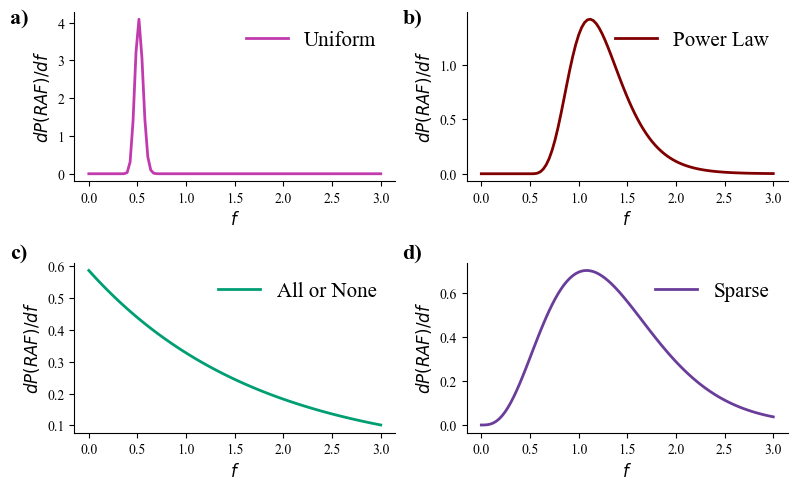

In [127]:
schemes =  {
    "Uniform":   "#C13BAF",  # deep turquoise
    "PowerLaw":  "maroon", #A02C2C",  # dark crimson
    "Sparse":    "#6A3D9A",  # vibrant purple
    "AllOrNone": "#009E73",  # teal green
}
f_sharp = np.linspace(0,3,100)


fig, axs = plt.subplots(2, 2, figsize=(8, 5))
(ax1, ax2), (ax3, ax4) = axs

ax1.plot(f_sharp, [len_X* binom.pmf(k_prime, mR -1, 2*f/len_R) for f in f_sharp], label = 'Uniform', color = schemes['Uniform'], lw = 2)
ax1.set_xlabel('$f$')
ax1.set_ylabel('$dP(RAF)/df$')
ax1.legend(fontsize = 15)

ax1.text(-0.2, 0.9, f"a)",
        transform=ax1.transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)

ax2.plot(f_sharp, [- powerlaw_empirical_derivative(k_prime, f, n) for f in f_sharp], label = 'Power Law',color = schemes['PowerLaw'], lw =2)
ax2.set_xlabel('$f$')
ax2.set_ylabel('$dP(RAF)/df$')
ax2.legend(fontsize = 15)

ax2.text(-0.2, 0.9, f"b)",
        transform=ax2.transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)

ax3.plot(f_sharp, [ allornone_derivative(f, len_X, len_R) for f in f_sharp], label = 'All or None',color = schemes['AllOrNone'], lw = 2)
ax3.set_xlabel('$f$')
ax3.set_ylabel('$dP(RAF)/df$')
ax3.legend(fontsize = 15)

ax3.text(-0.2, 1.0, f"c)",
        transform=ax3.transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)

ax4.plot(f_sharp, [sparse_derivative(k_prime, mR, f, len_R, len_X, n) for f in f_sharp], label = 'Sparse', color = schemes['Sparse'], lw = 2)
ax4.set_xlabel('$f$')
ax4.set_ylabel('$dP(RAF)/df$')
ax4.legend(fontsize = 15)

ax4.text(-0.2, 1.0, f"d)",
        transform=ax4.transAxes, ha='left', va='bottom',
        fontweight='bold', fontsize=16)

plt.tight_layout()
fig.savefig("Fig6.pdf",
            bbox_inches='tight', pad_inches=0.02)
plt.show()

In [ ]:
import numpy as np
import math
from scipy.stats import binom

# ---------- generic numerical helpers ----------

def pmf_from_cdf(cdf_func, i, f, *args, **kwargs):
    """P(k=i) from a CDF: pmf(i)=cdf(i)-cdf(i-1). Handles i=0."""
    if i <= 0:
        return cdf_func(0, f, *args, **kwargs)
    return cdf_func(i, f, *args, **kwargs) - cdf_func(i-1, f, *args, **kwargs)

def finite_diff_df(func, f, h=1e-3):
    """Central finite difference derivative d/df func(f)."""
    return (func(f + h) - func(f - h)) / (2*h)

def finite_diff_pmf_df_from_cdf(cdf_func, i, f, h=1e-3, *args, **kwargs):
    """d/df P(k=i) computed via pmf_from_cdf + finite differences in f."""
    g = lambda ff: pmf_from_cdf(cdf_func, i, ff, *args, **kwargs)
    return finite_diff_df(g, f, h=h)

def correction_sum(k_prime, f, q_func, dpk_df_func):
    """
    Computes sum_{i<k'} q(i) d/df P(k=i).
    q_func(i) can be a function or array-like (handled below).
    """
    total = 0.0
    for i in range(int(k_prime)):   # i = 0,...,k'-1
        qi = q_func(i) if callable(q_func) else q_func[i]
        if qi == 0:
            continue
        total += qi * dpk_df_func(i, f)
    return total


In [ ]:
def uniform_p_of_f(f, len_R):
    return 2*f / len_R

def uniform_dpk_df(i, f, S, len_R):
    """
    k ~ Binom(S-1, p), p=2f/len_R
    returns d/df P(k=i)
    """
    p = uniform_p_of_f(f, len_R)
    N = S - 1

    # guard rails
    if p <= 0 or p >= 1:
        return 0.0

    pmf = binom.pmf(i, N, p)
    dp_df = 2.0 / len_R
    dpmf_dp = pmf * (i/p - (N - i)/(1 - p))
    return dpmf_dp * dp_df

# Your existing "step term" (keep as-is if that's what you're using)
def uniform_step_term_df(k_prime, S, f, len_R, len_X):
    # matches your prior usage: len_X * binom.pmf(k_prime, S-1, 2f/len_R)
    return len_X * binom.pmf(k_prime, S - 1, 2*f/len_R)

def powerlaw_cdf(k, f, n):
    return powerlawCatalysis(n, f).cdf(k)

def powerlaw_dpk_df(i, f, n, h=1e-3):
    # derive pmf from cdf, then finite diff in f
    return finite_diff_pmf_df_from_cdf(powerlaw_cdf, i, f, h=h, n=n)

def powerlaw_step_term_df(k_prime, f, n, h=1e-3):
    # - d/df CDF(k'-1)
    g = lambda ff: powerlawCatalysis(n, ff).cdf(k_prime - 1)
    return -finite_diff_df(g, f, h=h)


def allornone_cdf(k, f, len_X, len_R):
    """
    TODO: define the CDF for k under your all-or-none scheme.
    If you already have it elsewhere, plug it in here.
    """
    raise NotImplementedError

def allornone_dpk_df(i, f, len_X, len_R, h=1e-3):
    return finite_diff_pmf_df_from_cdf(allornone_cdf, i, f, h=h, len_X=len_X, len_R=len_R)

def allornone_step_term_df(k_prime, f, len_X, len_R, h=1e-3):
    g = lambda ff: allornone_cdf(k_prime - 1, ff, len_X=len_X, len_R=len_R)
    return -finite_diff_df(g, f, h=h)


def sparse_cdf(k, f, mR, len_R, len_X, n):
    """
    TODO: implement the actual CDF for your sparse scheme.
    Once you have this, everything else drops in.
    """
    raise NotImplementedError

def sparse_dpk_df(i, f, mR, len_R, len_X, n, h=1e-3):
    return finite_diff_pmf_df_from_cdf(
        sparse_cdf, i, f, h=h, mR=mR, len_R=len_R, len_X=len_X, n=n
    )

def sparse_step_term_df(k_prime, f, mR, len_R, len_X, n, h=1e-3):
    g = lambda ff: sparse_cdf(k_prime - 1, ff, mR=mR, len_R=len_R, len_X=len_X, n=n)
    return -finite_diff_df(g, f, h=h)


def sharpness_df(k_prime, f, q_func, step_term_df, dpk_df_func):
    """
    Implements:
    dP(RAF)/df = step_term_df(f) + sum_{i<k'} q(i) dP(k=i)/df

    IMPORTANT:
      - Your equation has:  - d CDF(k'-1)/df  as the first term.
      - In the "step function" approximation where P(RAF|k)=1_{k>=k'},
        this equals d/df [1 - CDF(k'-1)].

    So: pass in step_term_df(f) that already equals  - d CDF(k'-1)/df.
    """
    return step_term_df(f) + correction_sum(k_prime, f, q_func, dpk_df_func)


### Misc: Enumrating Single Catalyst irrRAFS

In [ ]:
from typing import Dict, List, Tuple, Set

Sig = Tuple[Tuple[int, int], str]   # ((k_low, k_high), value)

def dict2sig(d: Dict[int, List[str]]) -> Sig:
    # assumes exactly 2 keys and each value is a 1-item list: ['A']
    (k1, v1), (k2, v2) = d.items()
    s1, s2 = v1[0], v2[0]
    if s1 != s2:
        # if your data *guarantees* equality you can remove this branch
        raise ValueError(f"Dict has mismatched values: {s1} vs {s2}")
    return ((k1, k2) if k1 < k2 else (k2, k1), s1)

def build_target_sigs(target: Dict[int, List[str]]) -> Set[Sig]:
    """
    Build all ((paired_keys), value) signatures from target.
    Uses the same odd/even pairing rule you’re using elsewhere: (2i, 2i+1).
    """
    sigs: Set[Sig] = set()
    for k, v in target.items():
        mate = k - 1 if (k % 2 == 1) else k + 1  # odd<->even
        if mate in target:
            s1 = v[0]
            s2 = target[mate][0]
            if s1 == s2:
                sigs.add(((mate, k) if mate < k else (k, mate), s1))
    return sigs

def any_key_value_match(target: Dict[int, List[str]], dict_list: List[Dict[int, List[str]]]) -> bool:
    target_sigs = build_target_sigs(target)
    for d in dict_list:
        # early exit on first hit
        if dict2sig(d) in target_sigs:
            #print('True')
            return True
    return False


In [301]:

N, n = 500, 6
X, F, R = create_XFR(n)
X_copy = X.copy()
F_copy = F.copy()
R_copy = R.copy()

react_count = len(R)

a1_count = 0
total_count = 0

for i in X:
    for j in range(1, react_count,2):
        C = {}
        F_copy = F.copy()
        R_copy = R.copy()
        
        k = -1
        if j in C.keys():
            if i not in C[j]:
                C[j].append(i)
        else:
            C[j]= [i]

        if j+k in C.keys():
            if i not in C[j+k]:
                C[j+k].append(i)
        else:
            C[j+k]= [i]

        total_count +=1 

        if RAF(F_copy, R_copy, C):
            print(C)
            a1_count += 1

{1: ['A'], 0: ['A']}
{3: ['A'], 2: ['A']}
{5: ['A'], 4: ['A']}
{7: ['A'], 6: ['A']}
{9: ['A'], 8: ['A']}
{11: ['A'], 10: ['A']}
{13: ['A'], 12: ['A']}
{15: ['A'], 14: ['A']}
{17: ['A'], 16: ['A']}
{19: ['A'], 18: ['A']}
{3: ['B'], 2: ['B']}
{5: ['B'], 4: ['B']}
{239: ['B'], 238: ['B']}
{241: ['B'], 240: ['B']}
{243: ['B'], 242: ['B']}
{245: ['B'], 244: ['B']}
{247: ['B'], 246: ['B']}
{249: ['B'], 248: ['B']}
{251: ['B'], 250: ['B']}
{253: ['B'], 252: ['B']}
{1: ['AA'], 0: ['AA']}
{7: ['AA'], 6: ['AA']}
{241: ['AA'], 240: ['AA']}
{243: ['AA'], 242: ['AA']}
{473: ['AA'], 472: ['AA']}
{475: ['AA'], 474: ['AA']}
{477: ['AA'], 476: ['AA']}
{479: ['AA'], 478: ['AA']}
{481: ['AA'], 480: ['AA']}
{483: ['AA'], 482: ['AA']}
{485: ['AA'], 484: ['AA']}
{3: ['AB'], 2: ['AB']}
{9: ['AB'], 8: ['AB']}
{11: ['AB'], 10: ['AB']}
{245: ['AB'], 244: ['AB']}
{247: ['AB'], 246: ['AB']}
{475: ['AB'], 474: ['AB']}
{477: ['AB'], 476: ['AB']}
{579: ['AB'], 578: ['AB']}
{581: ['AB'], 580: ['AB']}
{583: ['AB'], 58

In [ ]:
single_solutions = [{1: ['A'], 0: ['A']},
{3: ['A'], 2: ['A']},
{5: ['A'], 4: ['A']},
{7: ['A'], 6: ['A']},
{9: ['A'], 8: ['A']},
{11: ['A'], 10: ['A']},
{13: ['A'], 12: ['A']},
{15: ['A'], 14: ['A']},
{17: ['A'], 16: ['A']},
{19: ['A'], 18: ['A']},
{3: ['B'], 2: ['B']},
{5: ['B'], 4: ['B']},
{239: ['B'], 238: ['B']},
{241: ['B'], 240: ['B']},
{243: ['B'], 242: ['B']},
{245: ['B'], 244: ['B']},
{247: ['B'], 246: ['B']},
{249: ['B'], 248: ['B']},
{251: ['B'], 250: ['B']},
{253: ['B'], 252: ['B']},
{1: ['AA'], 0: ['AA']},
{7: ['AA'], 6: ['AA']},
{241: ['AA'], 240: ['AA']},
{243: ['AA'], 242: ['AA']},
{473: ['AA'], 472: ['AA']},
{475: ['AA'], 474: ['AA']},
{477: ['AA'], 476: ['AA']},
{479: ['AA'], 478: ['AA']},
{481: ['AA'], 480: ['AA']},
{483: ['AA'], 482: ['AA']},
{485: ['AA'], 484: ['AA']},
{3: ['AB'], 2: ['AB']},
{9: ['AB'], 8: ['AB']},
{11: ['AB'], 10: ['AB']},
{245: ['AB'], 244: ['AB']},
{247: ['AB'], 246: ['AB']},
{475: ['AB'], 474: ['AB']},
{477: ['AB'], 476: ['AB']},
{579: ['AB'], 578: ['AB']},
{581: ['AB'], 580: ['AB']},
{583: ['AB'], 582: ['AB']},
{585: ['AB'], 584: ['AB']},
{587: ['AB'], 586: ['AB']},
{5: ['BA'], 4: ['BA']},
{13: ['BA'], 12: ['BA']},
{15: ['BA'], 14: ['BA']},
{249: ['BA'], 248: ['BA']},
{251: ['BA'], 250: ['BA']},
{479: ['BA'], 478: ['BA']},
{481: ['BA'], 480: ['BA']},
{581: ['BA'], 580: ['BA']},
{583: ['BA'], 582: ['BA']},
{683: ['BA'], 682: ['BA']},
{685: ['BA'], 684: ['BA']},
{687: ['BA'], 686: ['BA']},
{17: ['BB'], 16: ['BB']},
{19: ['BB'], 18: ['BB']},
{239: ['BB'], 238: ['BB']},
{253: ['BB'], 252: ['BB']},
{483: ['BB'], 482: ['BB']},
{485: ['BB'], 484: ['BB']},
{585: ['BB'], 584: ['BB']},
{587: ['BB'], 586: ['BB']},
{685: ['BB'], 684: ['BB']},
{687: ['BB'], 686: ['BB']},
{783: ['BB'], 782: ['BB']},
{7: ['AAA'], 6: ['AAA']},
{9: ['AAB'], 8: ['AAB']},
{243: ['AAB'], 242: ['AAB']},
{11: ['ABA'], 10: ['ABA']},
{13: ['ABA'], 12: ['ABA']},
{17: ['ABB'], 16: ['ABB']},
{247: ['ABB'], 246: ['ABB']},
{15: ['BAA'], 14: ['BAA']},
{241: ['BAA'], 240: ['BAA']},
{245: ['BAB'], 244: ['BAB']},
{251: ['BAB'], 250: ['BAB']},
{19: ['BBA'], 18: ['BBA']},
{249: ['BBA'], 248: ['BBA']},
{253: ['BBB'], 252: ['BBB']},
{473: ['AAAA'], 472: ['AAAA']},
{475: ['AAAB'], 474: ['AAAB']},
{479: ['AABA'], 478: ['AABA']},
{483: ['AABB'], 482: ['AABB']},
{477: ['ABAA'], 476: ['ABAA']},
{579: ['ABAB'], 578: ['ABAB']},
{581: ['ABBA'], 580: ['ABBA']},
{585: ['ABBB'], 584: ['ABBB']},
{481: ['BAAA'], 480: ['BAAA']},
{583: ['BAAB'], 582: ['BAAB']},
{683: ['BABA'], 682: ['BABA']},
{685: ['BABB'], 684: ['BABB']},
{485: ['BBAA'], 484: ['BBAA']},
{587: ['BBAB'], 586: ['BBAB']},
{687: ['BBBA'], 686: ['BBBA']},
{783: ['BBBB'], 782: ['BBBB']},
]

In [ ]:
import json

with open("Github/single_solutions.json", "w") as f:
    json.dump(single_solutions, f)